## ML competition

_Marilyn, Shiva, Olivier_

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
tqdm.pandas()

# Lang detection
import langid
from langid.langid import LanguageIdentifier, model

identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)

In [3]:
df = pd.read_csv("data/MLUnige2021_train.csv")

### 1. EDA
Small EDA to check a bit the data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280000 entries, 0 to 1279999
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   Id         1280000 non-null  int64 
 1   emotion    1280000 non-null  int64 
 2   tweet_id   1280000 non-null  int64 
 3   date       1280000 non-null  object
 4   lyx_query  1280000 non-null  object
 5   user       1280000 non-null  object
 6   text       1280000 non-null  object
dtypes: int64(3), object(4)
memory usage: 68.4+ MB


More than a million entries. What is `lyx_query`? 

In [5]:
df["lyx_query"].head()
df["lyx_query"].unique()

array(['NO_QUERY'], dtype=object)

Welp only `"NO_QUERY"` so we can drop it. 

In [6]:
df["tweet_id"]

0          2063391019
1          2000525676
2          2218180611
3          2190269101
4          2069249490
              ...    
1279995    1835296397
1279996    2226720395
1279997    1962176213
1279998    1976894947
1279999    1563596981
Name: tweet_id, Length: 1280000, dtype: int64

Those are old tweets

In [7]:
df["date"]

0          Sun Jun 07 02:28:13 PDT 2009
1          Mon Jun 01 22:18:53 PDT 2009
2          Wed Jun 17 22:01:38 PDT 2009
3          Tue Jun 16 02:14:47 PDT 2009
4          Sun Jun 07 15:31:58 PDT 2009
                       ...             
1279995    Mon May 18 05:39:18 PDT 2009
1279996    Thu Jun 18 12:18:05 PDT 2009
1279997    Fri May 29 10:38:30 PDT 2009
1279998    Sat May 30 19:28:13 PDT 2009
1279999    Sun Apr 19 23:27:25 PDT 2009
Name: date, Length: 1280000, dtype: object

Indeed they are.

In [8]:
len(df["user"].unique())

574114

Lots of different users. If we had only like 1000s of users, we could have looked for some pattern (user X is only positive ...).

In [9]:
df.loc[0, ["emotion", "text"]]

emotion                                                    1
text       @BreeMe more time to play with you BlackBerry ...
Name: 0, dtype: object

In [10]:
df["emotion"].unique()

array([1, 0], dtype=int64)

In [11]:
df[df["emotion"]==1].shape[0] - df[df["emotion"]==0].shape[0]

236

Perfectly balanced dataset (236 diff between the 2 classes).

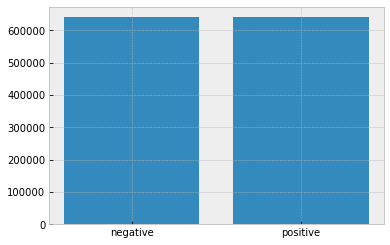

In [12]:
fig, ax = plt.subplots()
ax.bar(["negative", "positive"], [df[df["emotion"]==0].shape[0], df[df["emotion"]==1].shape[0]])
plt.show()

Let's also check the language of the tweets (all eng or also others?). For that, 

In [17]:
def lang_detect(txt, threshold=0.95):
    """
    Detect tweet language
    returns None if confidence lvl < threshold
    """

    if txt is None:
        return None

    txt = txt.replace("\n", " ")
    lang = identifier.classify(txt)
    if lang[0] < threshold:
        return None
    else:
        return lang[0]


In [26]:
df_samp = df.sample(150_000) #Total df takes 1h to run
df_samp["lang"] = df_samp["text"].progress_apply(lang_detect)
df_samp["lang"].unique()

100%|█████████████████████████████████████████████████████████████████████████| 150000/150000 [07:02<00:00, 355.30it/s]


array(['en', None, 'pt', 'sq', 'de', 'ru', 'vi', 'it', 'nl', 'sw', 'sv',
       'af', 'pl', 'mt', 'ga', 'lv', 'id', 'cs', 'fi', 'fr', 'no', 'es',
       'tl', 'da', 'cy', 'br', 'az', 'sk', 'ro', 'eo', 'wa', 'la', 'el',
       'sl', 'zh', 'et', 'ms', 'eu', 'hr', 'tr', 'mg', 'se', 'ca', 'xh',
       'nn', 'lb', 'rw', 'jv', 'hu', 'ku', 'ar', 'nb', 'lt', 'bg', 'th',
       'ko', 'he', 'oc', 'zu', 'or', 'mk', 'ne', 'bs', 'ta', 'ja', 'an'],
      dtype=object)

In [32]:
df_samp[~(df_samp["lang"] == "en")].count()

Id           15231
emotion      15231
tweet_id     15231
date         15231
lyx_query    15231
user         15231
text         15231
lang          1923
dtype: int64

Only 15k tweets which are not detected as english in our 150k sample. By checking some of the tweets, most are english, but the language detector surely has some trouble with some very short tweets containing one or more foreign words.

## 2. Strategy
1. take a sample of our whole dataset (200k?) to do our preliminary test. We can't do cross validation on the whole dataset.

2. Preprocess the text
    1. remove punctuation marks
    2. remove stopwords (en)
    3. stem or lemmatize the words

3. Begin to fit the models. 
    1. Pipeline with TfidfTransformer (or the other one I don't remember the name)
    2. BerNB
    3. LogisticRegression
    4. RidgeClassifier
    5. SGDClassifier
    6. SVC
    7. RandomForestClassifier
    8. DecisionTreeClassifier
    9. KNeighborsClassifier
    10. LDA? QDA?
4. Select a few of the best models, CV with bigger dataset
5. ...

## Misc

- Should pay attention to some special chars which were not removed: "I \&lt;3 you" (#2204), at first just remove it, but we could try investigate that